In [1090]:
import json
from collections import defaultdict
import re
import random
import string
import math
import numpy as np
from operator import itemgetter 


In [1091]:
def ingredient_exists(ingredient,list):
    for elem in list:
        if ingredient['name'] == elem['name']:
            return True
    return False

In [1092]:
recipes = []
bow = defaultdict(int)
roles = defaultdict(set)
ingredient_inverse = defaultdict(int)
ingredients_total = set()
ingredients_total_full = []
filtered = defaultdict(int)

counter = 0
with open('./data.json') as json_file:
    data = json.load(json_file)
    for p in data:
        recipes.append(p)
        for word in p['instructions'].lower().split(' '):
            bow[word] +=1


        
        for ing in p['ingredients']:
            ingredients_total.add(ing['name'])
            if not ingredient_exists(ing,ingredients_total_full):
                ingredients_total_full.append(ing)
            if 'role' not in ing: # remove this
                continue
            roles[ing['role']].add(ing['name'])

        
        for word_ing in ingredients_total:
            if word_ing in p['instructions']:
                filtered[word_ing] +=1



bow = {k: v for k, v in sorted(bow.items(), key=lambda item: item[1], reverse=True)}
filtered = {k: v for k, v in sorted(filtered.items(), key=lambda item: item[1], reverse=True)}



In [1093]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [recipe['title'] for recipe in recipes]
corpus_index = {k: v for k, v in enumerate(corpus)}
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

In [1094]:
for k ,v  in filtered.items():
    print("{} -> {}/{}".format(k, v, len(recipes)))

egg -> 1295/1668
sugar -> 1295/1668
flour -> 1266/1668
butter -> 1163/1668
salt -> 953/1668
vanilla -> 908/1668
baking soda -> 825/1668
cream -> 727/1668
brown sugar -> 508/1668
baking powder -> 468/1668
white sugar -> 397/1668
milk -> 335/1668
shortening -> 330/1668
chocolate chip -> 314/1668
oat -> 271/1668
vanilla extract -> 266/1668
margarine -> 245/1668
cinnamon -> 237/1668
walnut -> 220/1668
water -> 217/1668
confectioners' sugar -> 214/1668
chocolate -> 170/1668
peanut butter -> 162/1668
raisin -> 145/1668
coconut -> 142/1668
peanut -> 122/1668
butter or margarine -> 118/1668
cocoa -> 99/1668
nutmeg -> 82/1668
egg white -> 78/1668
almond -> 72/1668
lemon -> 70/1668
egg yolk -> 66/1668
almond extract -> 66/1668
cocoa powder -> 59/1668
cream of tartar -> 57/1668
honey -> 53/1668
apple -> 51/1668
cream cheese -> 50/1668
white chocolate -> 48/1668
rum -> 48/1668
ginger -> 47/1668
rolled oat -> 46/1668
vegetable oil -> 42/1668
oatmeal -> 42/1668
date -> 38/1668
sour cream -> 37/1668


In [1095]:
bow

{'the': 8023,
 'and': 7233,
 'to': 5413,
 'in': 5363,
 'a': 4445,
 'until': 3452,
 'degrees': 3193,
 'baking': 2681,
 'into': 2175,
 'oven': 1933,
 'on': 1887,
 'for': 1862,
 'with': 1770,
 'cookie': 1769,
 'stir': 1656,
 'dough': 1616,
 'f': 1564,
 'of': 1500,
 'together': 1411,
 'cool': 1339,
 'cookies': 1261,
 'sugar': 1199,
 'add': 1153,
 'minutes': 1140,
 'mix': 1140,
 'beat': 1089,
 'preheat': 1074,
 'butter': 1052,
 'flour,': 1037,
 'or': 993,
 '1': 983,
 'onto': 972,
 '350': 927,
 'preheated': 920,
 '2': 918,
 'mixture': 875,
 'bowl,': 855,
 '10': 842,
 'at': 837,
 'large': 817,
 '(175': 803,
 'about': 766,
 'cream': 744,
 'chocolate': 733,
 'place': 715,
 'sugar,': 708,
 'c).': 700,
 'wire': 698,
 'flour': 696,
 'by': 652,
 'brown': 605,
 'vanilla': 592,
 'lightly': 582,
 'sheet': 563,
 'minutes.': 562,
 'each': 545,
 'inches': 542,
 'roll': 539,
 'an': 539,
 'egg': 532,
 'white': 526,
 'bowl': 518,
 'are': 511,
 'before': 510,
 'butter,': 508,
 'inch': 501,
 'bake': 495,
 'so

In [1096]:
cup_equivalent = {
    'cup':1.0,
    'cups':1.0,
    'package':3.0,#random
    'packages': 3.0,
    'box': 4.0,#random
    'boxes': 4.0,
    'tablespoon':0.0625,
    'tablespoons':0.0625,
    'teaspoon': 0.02,
    'teaspoons': 0.02,
    'pound':3.5,
    'pounds':3.5,
    'pint':2.0,
    'pints':2.0,
    'jar':2.0,
    'jars':2.0,
    'stick':0.5,
    'sticks':0.5,
    'quart': 4,
    'quarts':4,
    'ounce':0.125,
    'ounces':0.125,
    'fluid': 0.125, #fluid ounces
    'fluids':0.125,
    'pinch': 0.001,
    'can':0.1,
    'units':1.0,
}
def quantity_norm(ingredient):
    if ingredient['measure'] not in cup_equivalent:
        #print(ingredient['measure'])
        return float(ingredient['quantity'])
    return float(ingredient['quantity']) * cup_equivalent[ingredient['measure']]

For the fitness function we wanted to encourage interesting recipes and ingredients, while keeping the recipes with the type of ingredients necessary to make it work. We used the following article, [How Ingredients Behave In A Cookie Recipe](https://www.instructables.com/How-Ingredients-Behave-In-A-Cookie-Recipe/), to get some insight on how different roles of ingredients interact to form the final cookie. The article mentions mandatory rules that apply to the making of every cookie: 
- "The rule of thumb for cookie baking is to always keep the amount of fat and sugar used relatively equal. There should be less than 1/4 cup difference between the two" - One of the fitness parameters for the recipes is how similiar are the fat and sugar quantities of the recipe
- "The amount of flour used should be about two times the amount of fat" - The second fitness parameter

To make the recipe achievable and believable we also want to limit the number of the flavoring ingredients by having a lower and upper limit. If the recipe steps outside the boundary this fitness parameter is reduced based on how much it is out of the boundary.
Since we are dealing with cookie recipes, theyThe should also not have too many total ingredients

To make the recipe interesting, rare items are encouradged by having a fitness parameter that is based on the average rarity of all the ingredients.

All this parameters have a multiplier that can be tuned to change how much each fitness parameter affects the final fitness score


In [1097]:
def total_quantity_role(ingredients,role):
    total = 0
    for ingredient in ingredients:
        if ingredient['role'] == role:
            total += quantity_norm(ingredient)
    return total
def total_number_role(ingredients,role):
    total = 0
    for ingredient in ingredients:
        if ingredient['role'] == role:
            total += 1
    return total
def calc_avg_novelty(ingredients):
    total = 0
    for ingredient in ingredients:
        for key,value in filtered.items():
            if key in ingredient['name']:
                total = total +  (1/value)
                #print(1/value)
                break
    #print('total: ',total)
    return total / len(ingredients)


In [1098]:
def fitness(recipe):
    fat_sugar_balance_mult = .3
    fat_sugar_flour_mult = .3
    min_number_flavoring_ingredients_mul = .3
    max_number_flavoring_ingredients_mul = .3
    max_number_ingredients_mul = 1
    avg_novelty_mul = 1.1
    #print('aaaa\n',recipe)
    ingredients = recipe['ingredients']
    num_ingredients = len(ingredients)
    number_flavoring_ingredients = total_number_role(ingredients,'flavor texture')
    total_sugar = total_quantity_role(ingredients,'sugar')
    total_fat = total_quantity_role(ingredients,'fat')
    total_flour = total_quantity_role(ingredients,'flour')
    
    fat_sugar_balance_fir = 0 if total_sugar+total_fat == 0 else (1 - abs(total_sugar-total_fat)/(total_sugar+total_fat))       #1
    fat_sugar_flour_fit = 0 if total_flour+total_fat == 0 else (1 - abs(total_flour-total_fat * 2)/(total_flour+total_fat * 2)) #2
    
    min_number_flavoring_ingredients_fit = 1 if number_flavoring_ingredients >=2 else   (1 - abs(2-number_flavoring_ingredients)/(2+number_flavoring_ingredients))             #3
    max_number_flavoring_ingredients_fit = 1 if number_flavoring_ingredients <=5 else   (1 - abs(5-number_flavoring_ingredients)/(5+number_flavoring_ingredients))             #3
    max_number_ingredients_fit = 1 if num_ingredients <=10 else   (1 - abs(10-num_ingredients)/(10+num_ingredients))         

    
    avg_novelty_fit = calc_avg_novelty(ingredients) # 4
    fitness_score = (
                       fat_sugar_balance_fir * fat_sugar_balance_mult  
                     + fat_sugar_flour_fit * fat_sugar_flour_mult
                     + min_number_flavoring_ingredients_fit * min_number_flavoring_ingredients_mul
                     + max_number_flavoring_ingredients_fit * max_number_flavoring_ingredients_mul
                     + max_number_ingredients_fit * max_number_ingredients_mul
                     + avg_novelty_fit * avg_novelty_mul
                     )
    fitness_score = round(fitness_score * 100)
    recipe['fitness'] = fitness_score
    #if fitness_score > 1000:
      #print(number_flavoring_ingredients_fit)
    #print(fitness_score)
    #print(fat_sugar_balance_fir,fat_sugar_flour_fit,number_flavoring_ingredients_fit,avg_novelty_fit)
    return fitness_score


In [1099]:
#re ={'title': 'VRKqObDCiQKrmywSdMse', 'ingredients': [{'measure': 'can', 'name': 'allspice', 'role': 'flavor texture', 'quantity': 1.7}], 'fitness': 8373}
#fitness(re)

In [1100]:
#print(fitness(recipes[5]))

for recipe in recipes:
    fitness(recipe)
#print(recipes)

1. Fat is added for flavor and controls how chewy or crunchy the cookie is. More fat = a chewier cookie, less fat = a crunchier cookie. 
2. Sugar is a sweetener (obviously!) and tenderizer, while controlling how much the cookie spreads. Adding sugar increases the spread of a cookie, so cookies with less sugar will be puffier. 

In [1101]:
def recipe_properties(recipe):
    ingredients = recipe['ingredients']
    total_sugar = total_quantity_role(ingredients,'sugar')
    total_fat = total_quantity_role(ingredients,'fat')
    total_flour = total_quantity_role(ingredients,'flour')
    recipe['properties'] = {}
    fat_to_others_ratio = 0 if total_sugar+total_fat+total_flour == 0 else (total_fat)/(total_sugar+total_fat+total_flour) #0.1-0.3
    sugar_to_others_ratio = 0 if total_sugar+total_fat+total_flour == 0 else (total_sugar)/(total_sugar+total_fat+total_flour) #0.2-0.4
    if fat_to_others_ratio <= 0.22:
        recipe['properties']['crunchiness'] = 'chewey'
    elif fat_to_others_ratio <= 0.25:
        recipe['properties']['crunchiness'] = 'normal'
    else: 
        recipe['properties']['crunchiness'] = 'crunchy'

    if sugar_to_others_ratio <= 0.22:
        recipe['properties']['spread'] = 'low'
    elif sugar_to_others_ratio <= 0.25:
        recipe['properties']['spread'] = 'normal'
    else: 
        recipe['properties']['spread'] = 'high'
    #print('not: ',total_sugar + total_flour,'fat: ',total_fat)
    #print('fat: ',fat_to_others_ratio)
    #print('sug: ',sugar_to_others_ratio)
    #print(recipe)

In [1102]:
# does not have quantities
def crossover_instructions(recipe1, recipe2, ingredients_final):

    # preheating
    regex ='preheat (\w+\s)+(\d+)\sdegrees F'
    result1 = re.search(regex, recipe1['instructions'],  re.IGNORECASE | re.MULTILINE)
    result2 = re.search(regex, recipe2['instructions'],  re.IGNORECASE | re.MULTILINE)

    
    temp1 = -1
    temp2 = -1

    if result1 != None:
        temp1 = int(result1.group(2))
    if result2 != None:
        temp2 = int(result2.group(2))

    if temp1 !=-1 and temp2 !=-1:
        temp = round(random.uniform(temp1, temp2),0)
    elif temp1 != -1:
        temp = temp1
    else:
        temp = temp2

    if temp != - 1:
        first_step = "Preheat the oven at " + str(temp) + " F degrees."
    else:
        first_step = ''
    # add fat and sugar
    first = []
    second = []
    third = []

    for ingredient in ingredients_final:
        if ingredient['role'] == 'fat' or ingredient['role'] == 'sugar':
            first.append(ingredient['name'])
        #flour, rising agent, binding agent
        elif ingredient['role'] == 'flour' or ingredient['role'] == 'rising agent' or ingredient['role'] == 'binding agent':
            second.append(ingredient['name'])
        # add flavour texture
        else:
            third.append(ingredient['name'])


    second_step = 'Add ' + ', '.join(first) + '. '
    second_step += 'Then add ' + ', '.join(second) + '. '
    second_step += 'Finally, join the following flavour textures: ' + ', '.join(third) +'. '


    # baking
    lower = 10000
    upper = -1
    regex2 = '((\d+) to)? (\d+) minutes'
    times1 = re.search(regex2, recipe1['instructions'],  re.IGNORECASE | re.MULTILINE)
    if times1 != None:
        #print(times1.groups())
        if times1.group(1) == None:
            lower = min(int(times1.group(3)),lower)
            upper = max(int(times1.group(3)), upper)

        else:
            lower = min(int(times1.group(2)), lower)
            upper = max(int(times1.group(3)), upper)

    times2 = re.search(regex2, recipe2['instructions'],  re.IGNORECASE | re.MULTILINE)

    if times2 != None:
        #print(times2.groups())
        if times2.group(1) == None:
            lower = min(int(times2.group(3)), lower)
            upper = max(int(times2.group(3)), upper)
        else:
            lower = min(int(times2.group(2)), lower)
            upper = max(int(times2.group(3)), upper)



    third_step = "Put the dough in the oven from " + str(lower) + " to " + str(upper) + " minutes. Take it from the oven and let it cool down."
    #print(third_step)
    return first_step + os.linesep + second_step + os.linesep + third_step


In [1103]:
def merge_titles(index1, index2, ingredients_new_recipe):
    #print(vectorizer.get_feature_names())
    ingredients_new_recipe = [x['name'].lower() for x in ingredients_new_recipe]
    print(ingredients_new_recipe)

    feature_names = vectorizer.get_feature_names()
    feature_index = X[index1,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [X[index1, x] for x in feature_index])
    
    pq = []
    name1 = ''
    first_high_score = -1
    first_characteristics = []
    for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
        first_characteristics.append(w)
        for ing in ingredients_new_recipe:
            if w in ing and first_high_score < s:
                name1 = w + ' '
                
            else:
                if w != 'cookies': 
                    pq.append((s, w))


    print("---")
    common_characteristics = []
    pq2 = []
    name2 = ' '
    second_high_score = -1
    feature_index = X[index2,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [X[index2, x] for x in feature_index])
    for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:

        if w == 'cookies':
            continue

        if w in first_characteristics and w != 'cookies':
            common_characteristics.append(w)

        for ing in ingredients_new_recipe:
            if w in ing and second_high_score < s:
                name2 = w + ' '
            else: 
                if w != 'cookies': 
                    pq2.append((s, w))

    sorted(pq, reverse=True)
    sorted(pq2, reverse=True)

    words = set([*common_characteristics, pq[0][1], pq[1][1]])

    if len(words) > 0:
        words =  ' '.join(words) + ' '
    else:
        words = ''

    ans = words + name1 + name2 + 'cookies'
    return ans


#print(recipes[3]['title'].lower())
#print(recipes[5]['title'].lower())
#merge_titles(3, 5, recipes[3]['ingredients'])

In [1104]:

# todo: quantities are missing
def crossover(recipe1, recipe2):
    ingredients1 = defaultdict(list)
    ingredients2 = defaultdict(list)
    roles = set()
    
    for ingredient in recipe1['ingredients']:
        roles.add(ingredient['role'])
        ingredients1[ingredient['role']].append(ingredient)
    for ingredient in recipe2['ingredients']:
        roles.add(ingredient['role'])
        ingredients2[ingredient['role']].append(ingredient)


    new_recipe = {}
    new_recipe['title'] = ''.join(random.choice(string.ascii_letters) for i in range((int( (len(recipe1['title']) + len(recipe2['title']))/2))))
    new_recipe['ingredients'] = []
    for role in roles:  
        nr1 = len(ingredients1[role])
        nr2 = len(ingredients2[role])
        
        if nr1 == 1 and nr2 == 1: #choose from one group
            r1 = random.randint(0, 1)
            if r1 == 0:
                new_recipe['ingredients'].append(ingredients2[role][0])
            else :
                new_recipe['ingredients'].append(ingredients2[role][0])

        elif nr1 + nr2 == 1:
            merged = ingredients1[role] + ingredients2[role]
            new_recipe['ingredients'].append(merged[0])

        else: # take more and less half of each

            #print(n1,n2)
            #indexes1=np.random.randint(0,nr1 ,math.ceil(nr1/2))
            indexes1 = random.sample(range(nr1),math.ceil(nr1/2))
            #print(indexes1)
            l1 = list(map(ingredients1[role].__getitem__, indexes1))
            indexes2 = random.sample(range(nr2),math.ceil(nr2/2))
            #print(indexes2)
           # indexes2= 0 if nr2 == 0 else np.random.randint(0,nr2 ,math.ceil(nr1/2))
            l2 = list(map(ingredients2[role].__getitem__, indexes2))
            #print(l1,l2)
            #s = set(l1 + l2)
            for ing in l1:
                new_recipe['ingredients'].append(ing)
            for ing in l2:
                new_recipe['ingredients'].append(ing)
    new_recipe['instructions'] = crossover_instructions(recipe1,recipe2,new_recipe['ingredients'])
    #new_recipe['title'] = merge_titles(recipe1['title'],recipe2['title'],new_recipe['ingredients'])
    return new_recipe

new_recipe = crossover(recipes[40], recipes[2])
#print(new_recipe)

In [1105]:
def mutation(recipe):
    r = random.randint(0,4)
    #r = 1
    r1 = random.randint(0, len(recipe['ingredients'])-1)

    # add randomly an ingredient:
    if r <= 2: 
        recipe['ingredients'].append(random.choice(ingredients_total_full))
    # remove randomly an element:
    if r == 3:
        recipe['ingredients'].pop(r1)
    # todo: change quantities

    # replace by other with the same role:
    if r == 4:
        role = recipe['ingredients'][r1]['role']
        r2 = random.randint(0, len(roles[role])-1)
        recipe['ingredients'][r1]['name'] = list(roles[role])[r2]
    return recipe


#print(new_recipe)
#mutation(recipes[0])

In [1106]:
def select_recipe(recipes):
  sum_fitness = sum([recipe['fitness'] for recipe in recipes])
  #print(sum_fitness)
  f = random.randint(0, sum_fitness)
  for recipe in recipes:
    if f < recipe['fitness']:
      return recipe
    f -= recipe['fitness']
  return recipes[-1]

In [1107]:
def normalise_recipe(recipe): #TODO: add ingredient quantities
    new_list = []
    a = False
    for ingredient in recipe['ingredients']:
        if not ingredient_exists(ingredient,new_list):
            new_list.append(ingredient)
        # else:
        #     for elem in new_list:
        #         a = True
        #         if ingredient['name'] == elem['name']:
        #             if ingredient['measure'] == elem['measure']:
        #                 elem['quantity'] = float(elem['quantity']) + float(ingredient['quantity'])
        #             else:
        #                 elem['quantity'] = quantity_norm(elem) + quantity_norm(ingredient)
        #                 elem['measure'] = 'cups'
                #print(elem)
    
    #if a:
        #print(new_list)
    recipe['ingredients'] = new_list

In [1108]:
def generate_recipes(size, population):
  R = []
  while len(R) < size:
    r1 = select_recipe(population)
    r2 = select_recipe(population)
    r = crossover(r1, r2)
    r = mutation(r)
    normalise_recipe(r)
    R.append(r)
    
  for r in R:
    fitness(r)
  return R

In [1109]:
def select_population(P, R):
  R = sorted(R, reverse = True, key = lambda r: r['fitness'])
  P = P[0:len(P)//4] + R[0:3*len(R)//4] #experimental
  P = sorted(P, reverse = True, key = lambda r: r['fitness'])
  return P

In [1110]:
iterations = 500
max_same_iters = 50
population_size = 100
population = random.choices(recipes, k=population_size)

population = sorted(population, reverse = True, key = lambda r: r['fitness'])
max_fitnesses = []
min_fitnesses = []
same_max_fitness_iters = 0
while same_max_fitness_iters <= 50 and iterations > 0:
  R = generate_recipes(population_size, population)
  population = select_population(population, R)
  if len(max_fitnesses) > 0 and max_fitnesses[-1] == population[0]['fitness']:
    same_max_fitness_iters += 1
  else:
    same_max_fitness_iters = 0
  max_fitnesses.append(population[0]['fitness'])
  min_fitnesses.append(population[-1]['fitness'])
  iterations -=1

In [1111]:
for rec in population:
    recipe_properties(rec)

jsonString = json.dumps(population[:10], indent=2, default=str)
jsonFile = open("generated_recipes.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

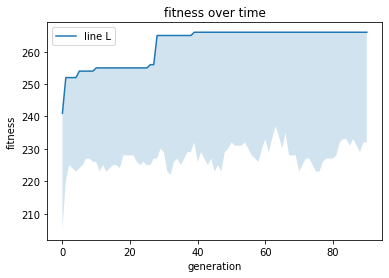

In [1112]:
import matplotlib.pyplot as plt
 
x  = range(len(max_fitnesses))
plt.plot(x, max_fitnesses, label="line L")
plt.fill_between(x, min_fitnesses, max_fitnesses, alpha=0.2)
plt.plot()

plt.xlabel("generation")
plt.ylabel("fitness")
plt.title("fitness over time")
plt.legend()
plt.show()

In [1113]:
#print(population[0])
#print(fitness(population[0]))
#print(population[0])

In [1114]:

recipes = []

graph = defaultdict(list)
replacements = []

ingredient_bag = defaultdict(int)


def parse_ingredient(line):

    line = line.lstrip()
    idx = 0
    # devemos tentar aqui separar as unidades ou simplesmente unidades + elementos são o proprio elemento?
    #while (line[idx].isdigit() or line[idx] == '/' or line[idx] == ' '):
    #    idx+=1
    
    #quantity = line [0 : idx].lstrip()
    
    ingredients = line[idx:].lower()

    ingredients = ingredients.split(' or ')

    for i in range(len(ingredients)):
        ingredients[i] = ingredients[i].lstrip()

    return quantity, ingredients

with open('./data.json') as json_file:
    data = json.load(json_file)
    for p in data:
        recipes.append(p)
        for i in range (len(p['ingredients']) - 1):
            for j in range( i + 1, len(p['ingredients'])):

                quantity, ingredients = parse_ingredient(p['ingredients'][i])
                quantity2, ingredients2 = parse_ingredient(p['ingredients'][j]) 

                if len(ingredients) > 1:
                    replacements.append(ingredients)

                if len(ingredients2) > 1:
                    replacements.append(ingredients2)

                for ing in ingredients:
                    graph[ing] += ingredients2
                    ingredient_bag[ing]+=1

                for ing in ingredients2:
                    graph[ing] += ingredients
                    ingredient_bag[ing]+=1
                


for k, v in ingredient_bag.items():
    print("{}->{}".format(k, v))
#for n in graph:
#    print("{} -> {}".format(n , len(graph[n])))

AttributeError: 'dict' object has no attribute 'lstrip'

In [ ]:
from queue import PriorityQueue

def calculate_distance(graph, ingredient):
    pq = PriorityQueue()
    dist = defaultdict(int)

    pq.put((0, ingredient ))
    dist[ingredient] = 0
    visited = set()

    while not pq.empty():
        u = pq.get()[1]
        for i in graph[u]:
            if i in visited:
                continue
            v = i
            visited.add(i)
            if v not in dist or dist[v] > dist[u] + 1:
                dist[v] = dist[u] + 1
                pq.put((dist[v], v))
    
    return dist



def calculate_distances(graph):   
    dist = {}
    for ingredient in graph:
        dist[ingredient] = calculate_distance(graph, ingredient)

    return dist


In [ ]:
dist = calculate_distances(graph) # act as a cache


In [ ]:
#print(dist.keys())

In [ ]:

def fitness(individual):
    counter = 0
    # the higher the worst
    pq = PriorityQueue()
    visited = set()
    for i in range(len(individual['ingredients']) - 1):
        for j in range(i + 1 , len(individual['ingredients'])):
            if i in visited and j in visited:
                continue
            pq.put(dist[individual['ingredients'][i]][individual['ingredients'][j]])

    while not pq.empty():
        u = pq.get()
        counter += u
    return counter

        
print(recipes[4])
print(fitness(recipes[4])) 
print(fitness(recipes[7]))


IndexError: list index out of range